# **Data Visualisation**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
sns.set_style("white")
from matplotlib.image import imread

# Change working directory

In [2]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\cmjim\\ml_pp5_drowsiness_detector\\jupyter_notebooks'

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir('C:\\Users\\cmjim\\ml_pp5_drowsiness_detector')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'C:\\Users\\cmjim\\ml_pp5_drowsiness_detector'

##  Set Input Directories

Set train, validation, and test directories

In [5]:
my_data_dir = r'inputs\drowsiness'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

## Set Output Directories

In [6]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir +
                                                                  '/outputs'):
    print(f'Old version is already available, change version variable'
          f'and create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Awake', 'Drowsy']


---

# Data Visualisation of Image Data

---

## Calculate Average Image Size for Training Set

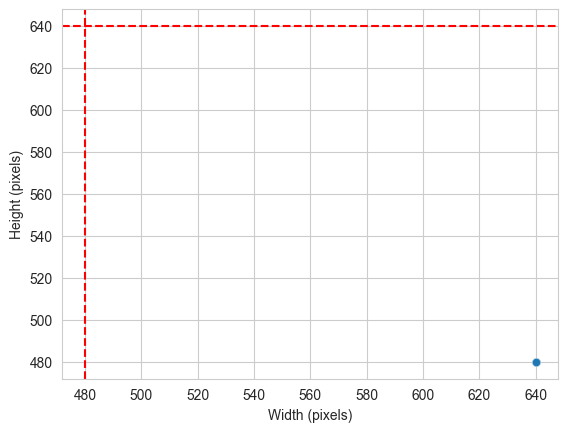

Width average: 640 
Height average: 480


In [8]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/'+ label):
        img = imread(train_path + '/' + label + '/'+ image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
        

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean().round())
dim2_mean = int(np.array(dim2).mean().round())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

## Image Sizing for Training Model

The size will be a quarter of the average from all the images in the train set to increase speed of model training

In [9]:
image_shape = (120, 160, 3)
image_shape

(120, 160, 3)

## Save the Image Shape Embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v3/image_shape.pkl']

---

# Average and Variablilty of Images per Label

## Function to Load Images into Tensor Array

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

## Load Image as Array

In [13]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 120, 160, 3) (60,)


---

## Plot and Save Mean and Variabilty of Images

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label Awake ====
Image Shape: (120, 160, 3)
==== Label Drowsy ====
Image Shape: (120, 160, 3)


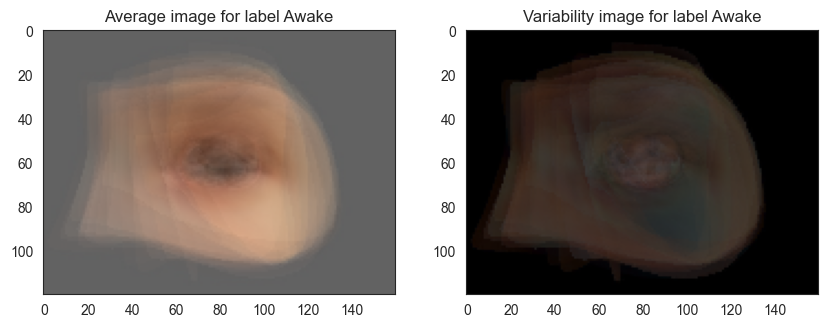

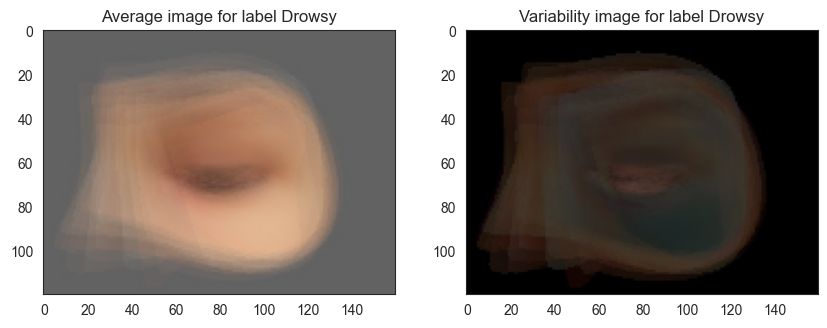

In [15]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)


---

## Assess Difference of Average Image of Awake Eyes against Drowsy Eyes

In [16]:
# Helper function for calculation of difference between average image
# labels. Tests whether associated label for NumPy image array matches
# label to display. Returns DataFrame containing image label.

def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

# Calculates average images for each label and plots the difference between
# average labels.

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # Label 1 Mean
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # Label 1 Mean
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # Label 1 and Label 2 differnce equation and subsequent graph plotting
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


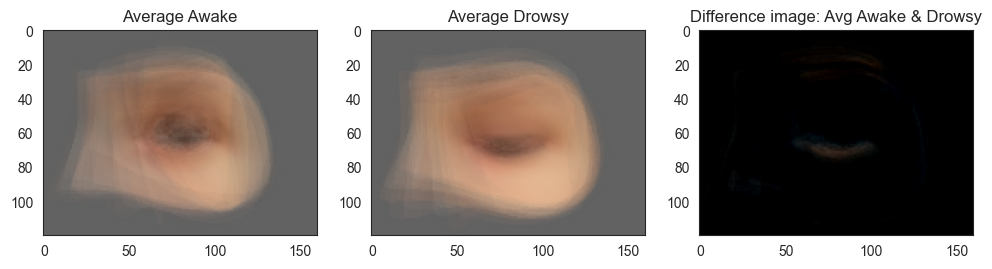

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='Awake',
                                        label_2='Drowsy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---